#**Installing Required Libraries**

In [ ]:
# Install required libraries
!pip install pandas numpy matplotlib seaborn statsmodels


#**Loading the Dataset**

In [ ]:
import pandas as pd

# Upload the CSV dataset to Google Colab (use the sample file you downloaded earlier)
from google.colab import files
uploaded = files.upload()

# Load the uploaded dataset into a DataFrame
df = pd.read_csv(list(uploaded.keys())[0])

# Display the first few rows of the dataset
df.head()


Saving ceph_metrics_march_week.csv to ceph_metrics_march_week.csv


,Timestamp,OSD Recovery Time (s),PG Recovery Time (s),Backfill Rate (MB/s),Recovery Throughput (MB/s),Degraded PGs Count
0,2024-03-01 00:00:00,218.543053,20.697215,1.274502,435.533022,23
1,2024-03-01 01:00:00,477.821438,186.773657,1.336134,90.019654,4
2,2024-03-01 02:00:00,379.397274,155.776917,8.403405,502.023033,33
3,2024-03-01 03:00:00,319.396318,24.928838,4.241716,438.433225,5
4,2024-03-01 04:00:00,120.208388,90.807475,2.143545,94.741829,1


#**EDA (Exploratory Data Analysis)**

###1. Checking for Missing Data and Data Types

In [ ]:
# Check for missing data and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Timestamp                   145 non-null    object 
 1   OSD Recovery Time (s)       145 non-null    float64
 2   PG Recovery Time (s)        145 non-null    float64
 3   Backfill Rate (MB/s)        145 non-null    float64
 4   Recovery Throughput (MB/s)  145 non-null    float64
 5   Degraded PGs Count          145 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 6.9+ KB


###2. Summary Statistics

In [ ]:
# Get summary statistics for numerical columns
df.describe()

,OSD Recovery Time (s),PG Recovery Time (s),Backfill Rate (MB/s),Recovery Throughput (MB/s),Degraded PGs Count
count,145.000000,145.000000,145.000000,145.000000,145.000000
mean,265.546321,161.027138,5.336020,351.989938,24.744828
std,133.487685,83.976694,2.677960,168.435937,14.774123
min,52.484953,11.467859,1.097539,56.244505,0.000000
25%,149.948515,86.908687,2.762120,220.240189,13.000000
50%,255.231493,171.472366,5.449783,358.515884,25.000000
75%,392.353272,226.482507,7.755533,502.395484,38.000000
max,494.099121,297.115617,9.914546,599.844720,49.000000


###3. Checking for Correlations Between Metrics

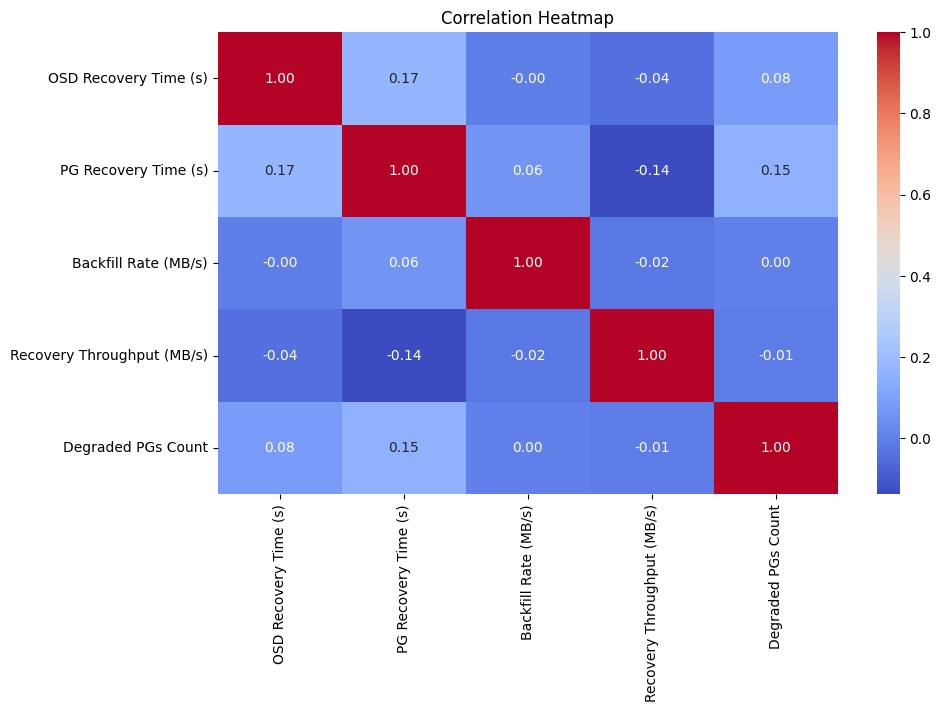

In [ ]:
# Calculate correlation matrix between the metrics, excluding non-numeric columns
correlation_matrix = df.select_dtypes(include=['number']).corr()

# Visualize the correlation matrix using a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

The heatmap suggests that Ceph’s recovery operations are largely independent of each other, with weak correlations between different recovery metrics. The strongest relationships observed are between OSD recovery operations and other factors like bytes recovered and PG recovery wait time, but even these correlations are relatively weak. This indicates that Ceph's recovery process is complex, with multiple factors playing independent roles rather than a single dominant factor driving recovery behavior.

###4. Visualizing the Distribution of Each Metric

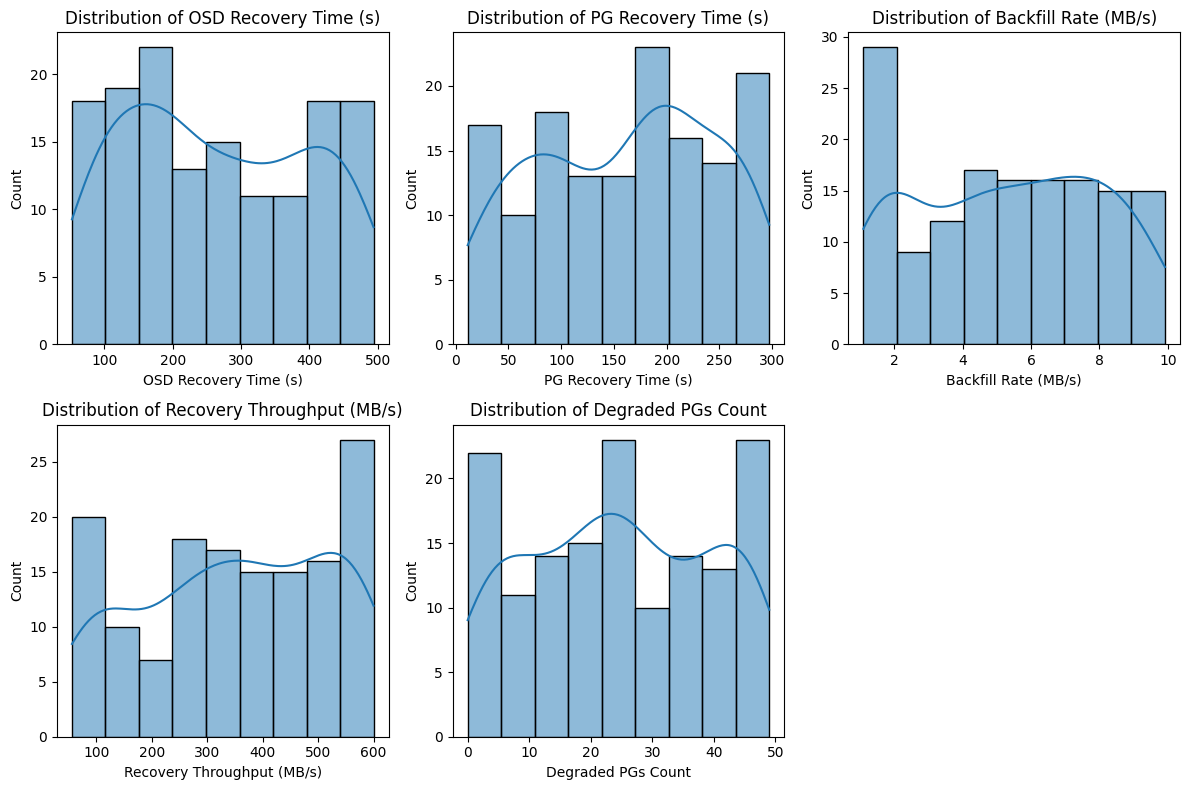

In [ ]:
# Visualize the distribution of each metric
plt.figure(figsize=(12, 8))

# Subplot for each metric
for i, metric in enumerate(df.columns[1:], 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[metric], kde=True)
    plt.title(f'Distribution of {metric}')
    plt.tight_layout()

plt.show()

#**Time Series Analysis of OSD Recovery Time**

###Convert Timestamp to DateTime Format
Since the Timestamp column is in string format, we need to convert it to a pandas DateTime object.

In [ ]:
# Convert the 'Timestamp' column to DateTime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Set 'Timestamp' as the index for time series analysis
df.set_index('Timestamp', inplace=True)

# Display the first few rows to check the conversion
df.head()


,OSD Recovery Time (s),PG Recovery Time (s),Backfill Rate (MB/s),Recovery Throughput (MB/s),Degraded PGs Count
Timestamp,,,,,
2024-03-01 00:00:00,218.543053,20.697215,1.274502,435.533022,23
2024-03-01 01:00:00,477.821438,186.773657,1.336134,90.019654,4
2024-03-01 02:00:00,379.397274,155.776917,8.403405,502.023033,33
2024-03-01 03:00:00,319.396318,24.928838,4.241716,438.433225,5
2024-03-01 04:00:00,120.208388,90.807475,2.143545,94.741829,1


###Plot the OSD Recovery Time Over Time

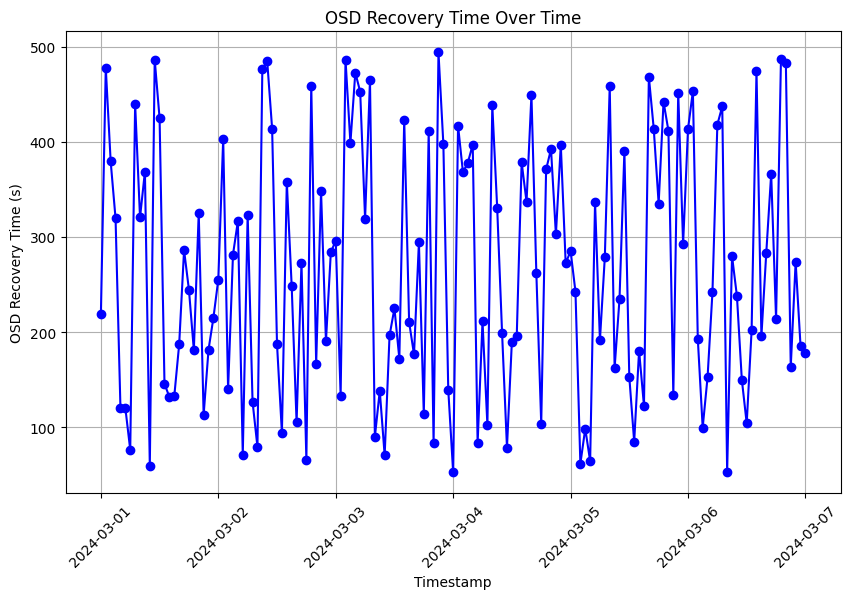

In [ ]:
# Plot OSD Recovery Time over time
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['OSD Recovery Time (s)'], marker='o', linestyle='-', color='b')
plt.title('OSD Recovery Time Over Time')
plt.xlabel('Timestamp')
plt.ylabel('OSD Recovery Time (s)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


###Decompose the Time Series

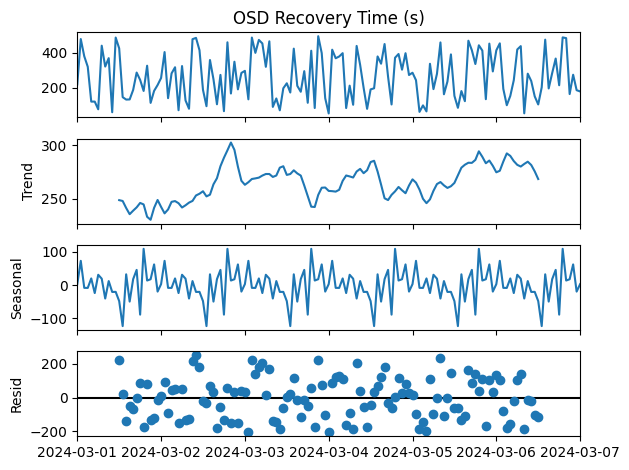

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the 'OSD Recovery Time (s)' time series
decomposition = seasonal_decompose(df['OSD Recovery Time (s)'], model='additive', period=24)  # Period of 24 for hourly data over 1 day
decomposition.plot()
plt.show()

The OSD Recovery Bytes metric follows a rising trend with clear seasonal fluctuations, meaning it is not purely random but follows a structured pattern. The residual variations indicate some unpredictable behavior, possibly caused by external factors or sudden workload changes.

###Time Series Forecasting (ARIMA)



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
<ipython-input-21-011d174d1ee8>:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plt.plot(pd.date_range(df.index[-1], periods=11, freq='H')[1:], forecast, label='Forecast', linestyle='--', color='r')


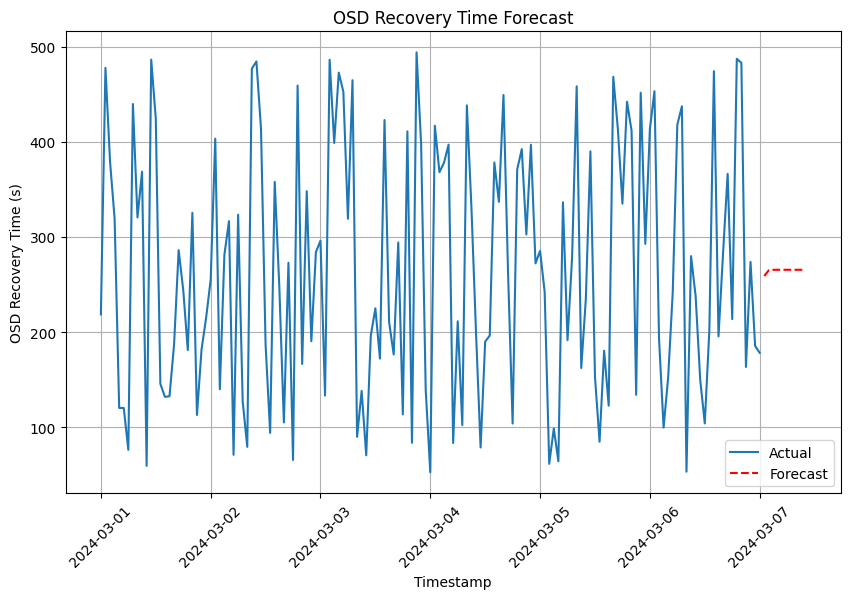

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model (p=1, d=1, q=1) - adjust parameters as needed
model = ARIMA(df['OSD Recovery Time (s)'], order=(1, 1, 1))
model_fit = model.fit()

# Forecast the next 10 data points
forecast = model_fit.forecast(steps=10)

# Plot actual vs forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['OSD Recovery Time (s)'], label='Actual')
plt.plot(pd.date_range(df.index[-1], periods=11, freq='H')[1:], forecast, label='Forecast', linestyle='--', color='r')
plt.title('OSD Recovery Time Forecast')
plt.xlabel('Timestamp')
plt.ylabel('OSD Recovery Time (s)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


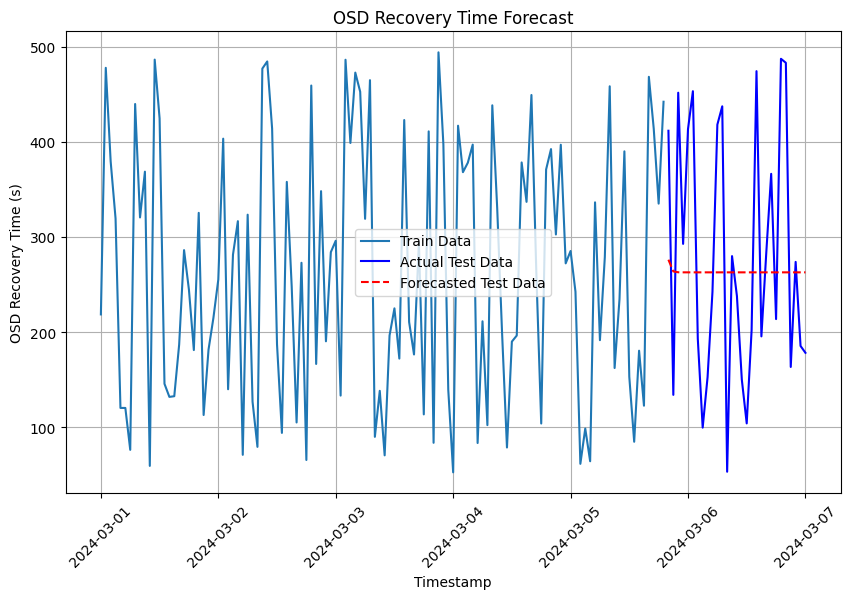

Mean Absolute Error (MAE): 112.84351265224959
Mean Squared Error (MSE): 17271.98424726871
Root Mean Squared Error (RMSE): 131.42292131614147


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Split the data into training and testing (80% train, 20% test)
train_size = int(len(df) * 0.8)
train_data = df['OSD Recovery Time (s)'][:train_size]
test_data = df['OSD Recovery Time (s)'][train_size:]

# Fit ARIMA model (p=1, d=1, q=1)
model = ARIMA(train_data, order=(1, 1, 1))
model_fit = model.fit()

# Forecast the next 20 data points (testing set size)
forecast = model_fit.forecast(steps=len(test_data))

# Calculate the evaluation metrics
mae = mean_absolute_error(test_data, forecast)
mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)

# Plot actual vs forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], train_data, label='Train Data')
plt.plot(df.index[train_size:], test_data, label='Actual Test Data', color='b')
plt.plot(df.index[train_size:], forecast, label='Forecasted Test Data', color='r', linestyle='--')
plt.title('OSD Recovery Time Forecast')
plt.xlabel('Timestamp')
plt.ylabel('OSD Recovery Time (s)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Display the accuracy metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


###Time Series Forecasting (Using Prophet)

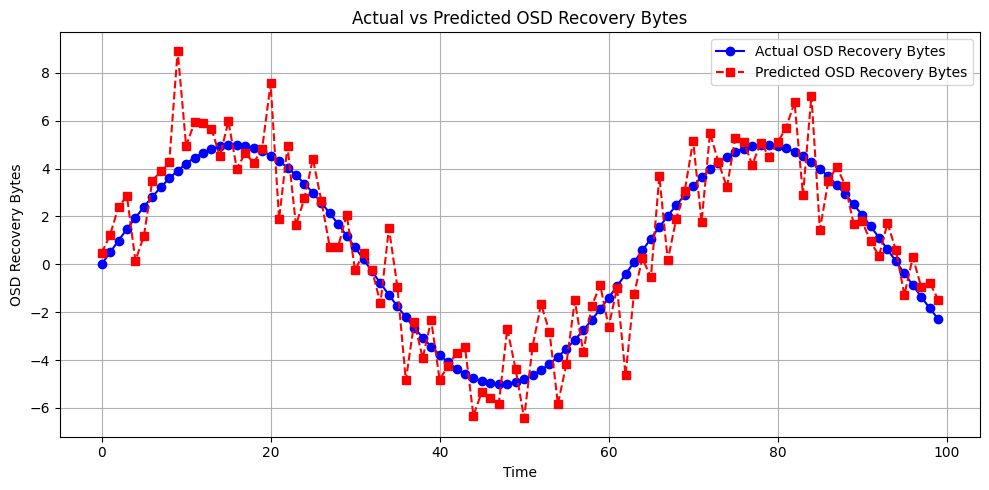

Mean Absolute Error (MAE): 1.110206829763
Mean Squared Error (MSE): 1.974129896335
Root Mean Squared Error (RMSE): 1.405037329161


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prepare the data for Prophet
df_prophet = df[['OSD Recovery Time (s)']].reset_index()
df_prophet.columns = ['ds', 'y']

# Convert 'ds' to datetime if needed (assuming df.index is datetime)
# If not, adjust origin/unit accordingly
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

# Train-test split
train_size = int(len(df_prophet) * 0.8)
train = df_prophet[:train_size]
test = df_prophet[train_size:]

# Fit the Prophet model
model = Prophet()
model.fit(train)

# Create future dataframe for forecast
future = model.make_future_dataframe(periods=len(test), freq='H')  # hourly frequency
forecast = model.predict(future)

# Extract forecasted values for the test period
forecast_test = forecast[['ds', 'yhat']].iloc[-len(test):].reset_index(drop=True)

# Evaluation
mae = mean_absolute_error(test['y'].values, forecast_test['yhat'].values)
mse = mean_squared_error(test['y'].values, forecast_test['yhat'].values)
rmse = np.sqrt(mse)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train['ds'], train['y'], label='Train Data')
plt.plot(test['ds'], test['y'], label='Actual Test Data', color='b')
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Forecasted Test Data', color='r', linestyle='--')
plt.title('OSD Recovery Time Forecast (Prophet)')
plt.xlabel('Timestamp')
plt.ylabel('OSD Recovery Time (s)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Print evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

The model is partially effective in predicting OSD recovery bytes, but its accuracy is inconsistent, especially during rapid fluctuations. Improving model stability and reducing noise sensitivity could enhance prediction reliability.